# CMRL Live Ridership Information

Live data from the Chennai Metro is available on CMRL's portal at [https://commuters-data.chennaimetrorail.org/passengerflow](https://commuters-data.chennaimetrorail.org/passengerflow) with existing visualisations.

This Notebook will go through manipulating the source JSON response data from CMRL's API (Found through network traffic analysis on the website) in order to recreate the same visualisations. We will then explore how we can extrapolate more information, learn about the metro network, and some observations and scripts we can make and what they signify in the real world.

### Collecting and basic processing of bulk data

In [13]:
import requests

base_url = "https://commuters-dataapi.chennaimetrorail.org/api/PassengerFlow/"
day = "1" # '1' for previous day, '0' for current day
# Note : Depending on time of day, /0 may have incomplete data. Since we would rather deal with complete data, we use /1.

daily_ticket_count_url = base_url + "allTicketCount/" + day
hourly_passenger_data_url = base_url + "hourlybaseddata/" + day
station_flow_data_url = base_url + "stationData/" + day

In [ ]:
import pandas as pd

def get_daily_ticket_count():
    response = requests.get(daily_ticket_count_url).json()
    return response

def get_hourly_passenger_data():
    response = requests.get(hourly_passenger_data_url).json()
    hourly_data = {
        'timestamps': [pd.to_datetime(ts).strftime('%H:%M') for ts in response['categories']],
        'series': {s['name']: s['data'] for s in response['series']}
    }
    return hourly_data

def get_station_flow_data():
    response = requests.get(station_flow_data_url).json()
    station_data = {}
    for line_data in response:
        line_number = line_data['line']
        station_data[line_number] = {
            'categories': line_data['categories'], # Station names
            'series': {s['name']: s['data'] for s in line_data['series']}
        }
    return station_data

daily_tickets = get_daily_ticket_count()
hourly_passengers = get_hourly_passenger_data()
station_flows = get_station_flow_data()

print("Daily Ticket Count (first 5 items):", dict(list(daily_tickets.items())[:5]))
print("\nHourly Passenger Data (timestamps and a sample series):\nTimestamps:", hourly_passengers['timestamps'][:5], "\nTotal Series (first 5 data points):", hourly_passengers['series']['Total'][:5])
print("\nStation Flow Data (sample for line 01, categories and a sample series):\nCategories:", station_flows['01']['categories'][:5], "\nTotal Series (first 5 data points for Line 01):", station_flows['01']['series']['Total'][:5])

Daily Ticket Count (first 5 items): {'totalTickets': 366896, 'noOfSVC': 1518, 'noOfNCMCcard': 210183, 'noOfMobileQR': 3995, 'noOfStaticQR': 7287}

Hourly Passenger Data (timestamps and a sample series):
Timestamps: ['00:00', '01:00', '02:00', '03:00', '04:00'] 
Total Series (first 5 data points): [13, 1, 8, 10, 1422]

Station Flow Data (sample for line 01, categories and a sample series):
Categories: ['WIMCO NAGAR DEPOT', 'WIMCO NAGAR METRO', 'THIRUVOTRIYUR METRO', 'THIRUVOTRIYUR THERADI METRO', 'KALADIPET METRO'] 
Total Series (first 5 data points for Line 01): [5030, 5439, 4632, 5705, 4883]


### Recreating the CMRL Dashboards

Now that we have access to the same data as the official dashboard, let's try to make an authentic recreation of the visualisations they provide

[Here is the official Passenger Flow website](https://commuters-data.chennaimetrorail.org/passengerflow)

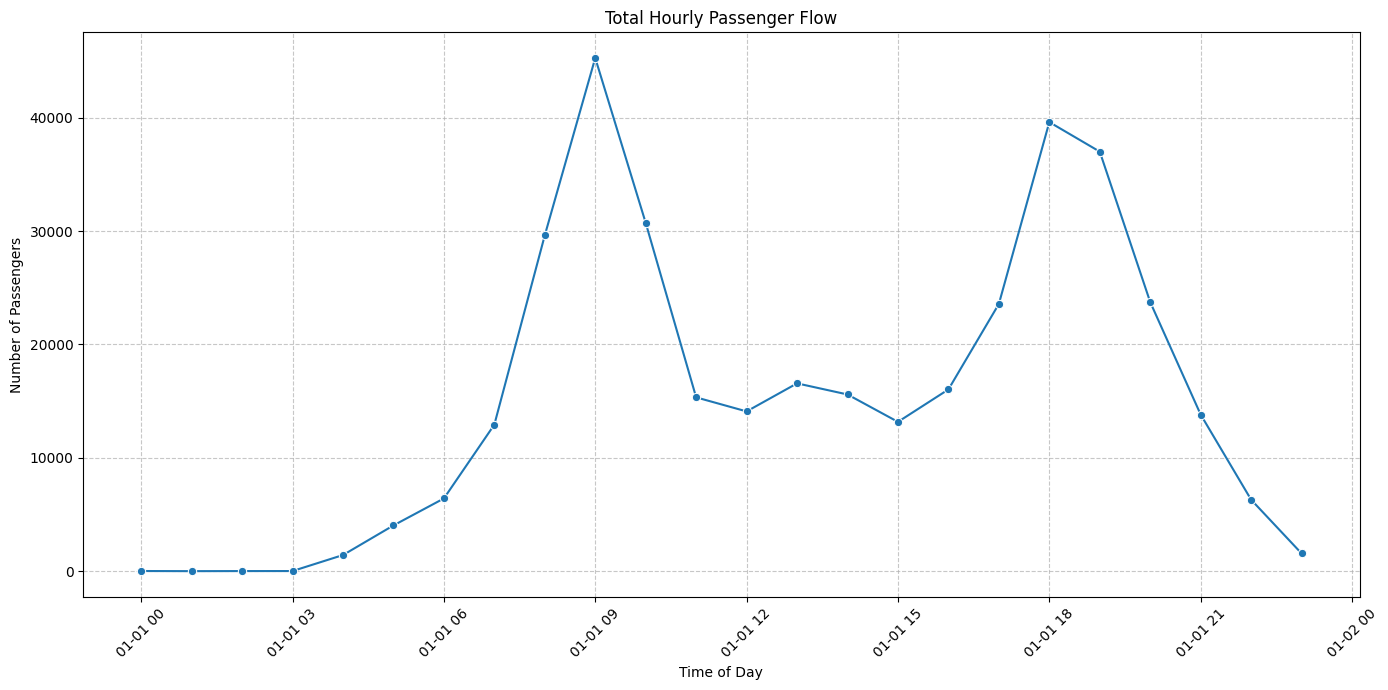

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

hourly_df = pd.DataFrame({
    'Time': hourly_passengers['timestamps'],
    'Total Passengers': hourly_passengers['series']['Total']
})

# Convert 'Time' to datetime objects for proper sorting and plotting on the x-axis
hourly_df['Time'] = pd.to_datetime(hourly_df['Time'], format='%H:%M')

# Sort by time to ensure the plot is ordered correctly
hourly_df = hourly_df.sort_values(by='Time')

plt.figure(figsize=(14, 7))
sns.lineplot(x='Time', y='Total Passengers', data=hourly_df, marker='o')

plt.title('Total Hourly Passenger Flow')
plt.xlabel('Time of Day')
plt.ylabel('Number of Passengers')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### Hourly Passenger Flow with Payment Method Share

This plot visualizes the total hourly passenger flow as a bar graph, with each individual payment method shown as a cumulative line graph on top. This allows us to see the share of each fare method contributing to the total passenger count at any given hour.

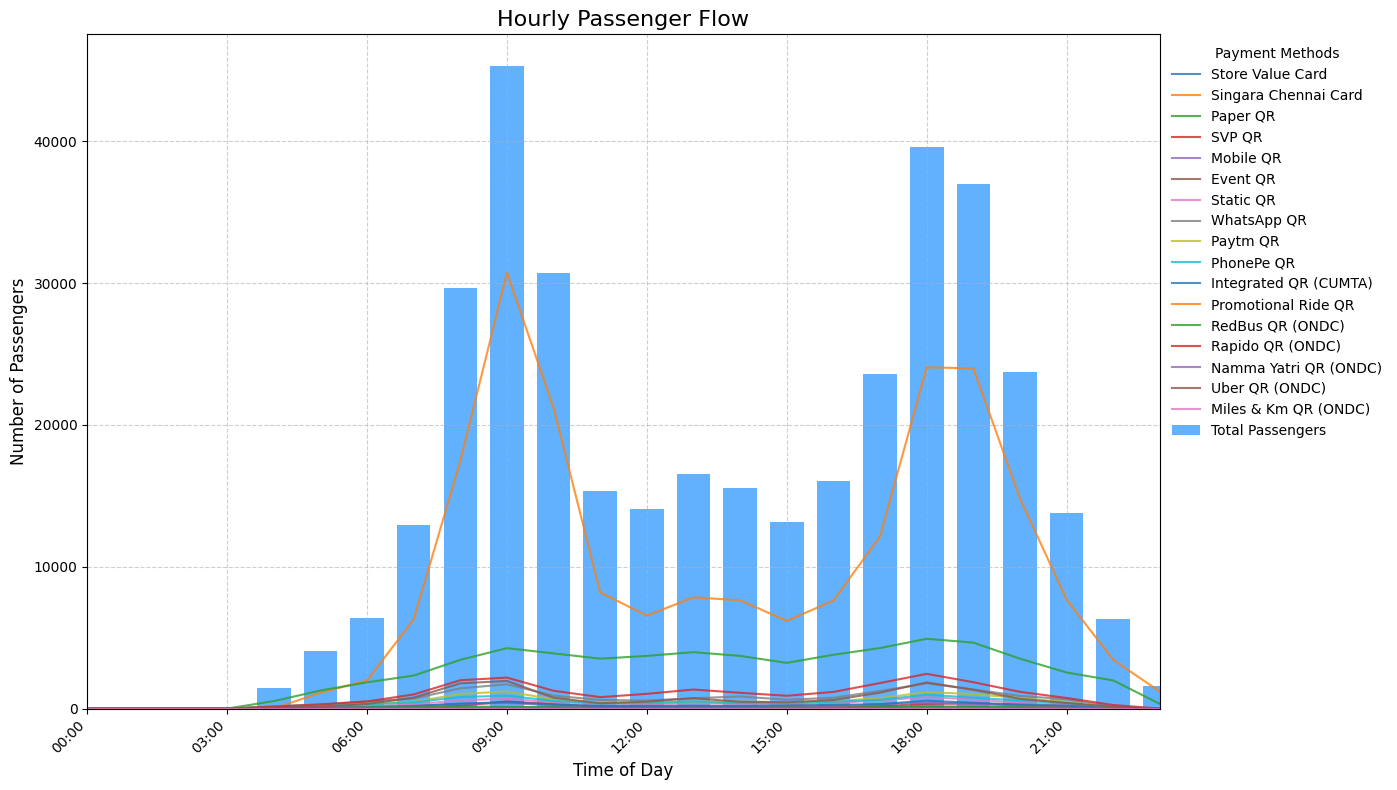

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.dates import DateFormatter

# Use hour for x-axis
df_plot = pd.DataFrame({
    'Time_str': hourly_passengers['timestamps'],
    'Total': hourly_passengers['series']['Total'] # Base layer is total passengers
})
df_plot['Time_dt'] = pd.to_datetime(df_plot['Time_str'], format='%H:%M')

# Sort data by time
df_plot = df_plot.sort_values('Time_dt').reset_index(drop=True)

# Add individual payment methods data
payment_methods = [name for name in hourly_passengers['series'].keys() if name != 'Total']
for method in payment_methods:
    df_plot[method] = hourly_passengers['series'][method]

# Plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot Total as a bar graph
ax.bar(df_plot['Time_dt'], df_plot['Total'], width=0.03, align='center', label='Total Passengers', color='dodgerblue', alpha=0.7)

# Plot each individual payment method as a separate line graph
for method in payment_methods:
    ax.plot(df_plot['Time_dt'], df_plot[method], label=method, alpha=0.8)

plot_title = 'Hourly Passenger Flow'
ax.set_title(plot_title, fontsize=16)
ax.set_xlabel('Time of Day', fontsize=12)
ax.set_ylabel('Number of Passengers', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45, ha='right')

min_time = df_plot['Time_dt'].min()
max_time = df_plot['Time_dt'].max()
ax.set_xlim(min_time, max_time)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), title='Payment Methods', frameon=False)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

### Interactive Hourly Passenger Flow with Payment Method Share

The actual dashboard on the website isn't static, when hovering over a certain hour, it lets us view the actual numbers for each payment method. We can use plotly to make an interactive version of the existing dashboard.

In [17]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# readable date format
first_timestamp_raw = hourly_passengers['timestamps'][0]
date_obj = pd.to_datetime(first_timestamp_raw)
readable_date = date_obj.strftime('%B %d, %Y')

# Base bar graph of totals
fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_plot['Time_dt'],
    y=df_plot['Total'],
    name='Total Passengers',
    marker_color='lightgray',
    opacity=0.7,
    hovertemplate='<b>Total Passengers</b>: %{y}<extra></extra>'
))

# Add individual payment method line traces
payment_methods = [name for name in hourly_passengers['series'].keys() if name != 'Total']
for method in payment_methods:
    fig.add_trace(go.Scatter(
        x=df_plot['Time_dt'],
        y=df_plot[method],
        mode='lines',
        name=method,
        hovertemplate='<b>'+method+'</b>: %{y}<extra></extra>'
    ))

# Title with date
base_plot_title = f'Interactive Hourly Passenger Flow with Payment Method Share ({readable_date})'

fig.update_layout(
    title_text=base_plot_title,
    xaxis_title='Time of Day',
    yaxis_title='Number of Passengers',
    xaxis_tickformat='%H:%M',
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.15,
        xanchor="center",
        x=0.5
    ),
    height=600,
    margin=dict(t=100, b=150)
)

fig.show()

### Station-wise Passenger Flow

Recreating the other two graphs depicting stations-wise passenger flow on the Blue and Green metro lines

### Line 1 - Blue

In [18]:
line_01_data = station_flows['01']
stations = line_01_data['categories']
df_line_01 = pd.DataFrame({'Station': stations})
df_line_01['Total Passengers'] = line_01_data['series']['Total']

for method_name, data in line_01_data['series'].items():
    if method_name != 'Total':
        df_line_01[method_name] = data

print("DataFrame for Line 01 (first 5 rows):\n", df_line_01.head())

DataFrame for Line 01 (first 5 rows):
                        Station  Total Passengers  Store Value Card  \
0            WIMCO NAGAR DEPOT              5030                11   
1            WIMCO NAGAR METRO              5439                12   
2          THIRUVOTRIYUR METRO              4632                 4   
3  THIRUVOTRIYUR THERADI METRO              5705                15   
4              KALADIPET METRO              4883                11   

   Singara Chennai Card  Paper QR  SVP QR  Mobile QR  Event QR  Static QR  \
0                  3231       824      33         29         0         73   
1                  3352       738      54         68         0         86   
2                  3338       441      24         39         0         69   
3                  3789       779      55         49         0         64   
4                  3417       569      24         21         0         61   

   WhatsApp QR  Paytm QR  PhonePe QR  Integrated QR (CUMTA)  \
0          131

In [ ]:
import plotly.graph_objects as go

fig_line_01 = go.Figure()

# bar graph for totals
fig_line_01.add_trace(go.Bar(
    x=df_line_01['Station'],
    y=df_line_01['Total Passengers'],
    name='Total Passengers',
    marker_color='lightgray',
    opacity=0.7,
    hovertemplate='<b>Total Passengers</b>: %{y}<extra></extra>'
))

# line graph for individual
payment_method_columns = [col for col in df_line_01.columns if col not in ['Station', 'Total Passengers']]
for method in payment_method_columns:
    fig_line_01.add_trace(go.Scatter(
        x=df_line_01['Station'],
        y=df_line_01[method],
        mode='lines',
        name=method,
        hovertemplate='<b>' + method + '</b>: %{y}<extra></extra>'
    ))

# layout
fig_line_01.update_layout(
    title_text='Interactive Station-wise Passenger Flow (Line 01 - Blue)',
    xaxis_title='Station',
    yaxis_title='Number of Passengers',
    hovermode='x unified',
    legend=dict(
        orientation="h",    
        yanchor="top",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    height=600,
    margin=dict(t=100, b=150)
)

fig_line_01.show()

### Line 2 - Green

In [20]:
import pandas as pd

line_02_data = station_flows['02']
stations_line_02 = line_02_data['categories']
df_line_02 = pd.DataFrame({'Station': stations_line_02})

# total
df_line_02['Total Passengers'] = line_02_data['series']['Total']

# individual
for method_name, data in line_02_data['series'].items():
    if method_name != 'Total':  # Skip 'Total' as it's already added
        df_line_02[method_name] = data

print("DataFrame for Line 02 (first 5 rows):\n", df_line_02.head())

DataFrame for Line 02 (first 5 rows):
                 Station  Total Passengers  Store Value Card  \
0        CENTRAL  METRO             14537                58   
1                EGMORE              7907                30   
2            NEHRU PARK              2868                13   
3               KILPAUK              2679                11   
4  PACHAIAPPA S COLLEGE              3149                16   

   Singara Chennai Card  Paper QR  SVP QR  Mobile QR  Event QR  Static QR  \
0                  4245      5898     194        492         0        534   
1                  2471      2812      43        131         0        172   
2                  1648       491      26         27         0         38   
3                  1374       558      18         24         0         47   
4                  1881       481      20         24         0         32   

   WhatsApp QR  Paytm QR  PhonePe QR  Integrated QR (CUMTA)  \
0          653       372         660                    

In [22]:
import plotly.graph_objects as go

fig_line_02 = go.Figure()

# bar
fig_line_02.add_trace(go.Bar(
    x=df_line_02['Station'],
    y=df_line_02['Total Passengers'],
    name='Total Passengers',
    marker_color='lightgray',
    opacity=0.7,
    hovertemplate='<b>Total Passengers</b>: %{y}<extra></extra>'
))

payment_method_columns_line_02 = [col for col in df_line_02.columns if col not in ['Station', 'Total Passengers']]

# line
for method in payment_method_columns_line_02:
    fig_line_02.add_trace(go.Scatter(
        x=df_line_02['Station'],
        y=df_line_02[method],
        mode='lines',
        name=method,
        hovertemplate='<b>' + method + '</b>: %{y}<extra></extra>'
    ))

# layout
fig_line_02.update_layout(
    title_text='Interactive Station-wise Passenger Flow (Line 02 - Green)',
    xaxis_title='Station',
    yaxis_title='Number of Passengers',
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    height=600,
    margin=dict(t=100, b=150)
)

fig_line_02.show()